# Import

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


# Check Folder

In [2]:
fashion_dataset_path="Dataset_Split/train"
os.listdir(fashion_dataset_path)

['Anorak',
 'Blazer',
 'Blouse',
 'Bomber',
 'Button-Down',
 'Caftan',
 'Capris',
 'Cardigan',
 'Chinos',
 'Coat',
 'Coverup',
 'Culottes',
 'Cutoffs',
 'Dress',
 'Flannel',
 'Gauchos',
 'Halter',
 'Henley',
 'Hoodie',
 'Jacket',
 'Jeans',
 'Jeggings',
 'Jersey',
 'Jodhpurs',
 'Joggers',
 'Jumpsuit',
 'Kaftan',
 'Kimono',
 'Leggings',
 'Onesie',
 'Parka',
 'Peacoat',
 'Poncho',
 'Robe',
 'Romper',
 'Sarong',
 'Shorts',
 'Skirt',
 'Sweater',
 'Sweatpants',
 'Sweatshorts',
 'Tank',
 'Tee',
 'Top',
 'Trunks',
 'Turtleneck']

# Import Pretrained Model VGG16

In [3]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False)
conv_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# Load Dataset

In [4]:
TRAINING_DIR = "Dataset_Split/train"
VALIDATION_DIR = "Dataset_Split/val"
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 3

def DataLoad(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''   
    training_datagen = ImageDataGenerator(
        rescale = 1./255,
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1)

    validation_datagen = ImageDataGenerator(rescale = 1./255)
    
    height, width = shape

    train_dataset = training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(height, width),
        class_mode='categorical',
        batch_size=batch_size
    )

    val_dataset = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(height, width),
        class_mode='categorical',
        batch_size=batch_size
    )
    return train_dataset, val_dataset

In [5]:
train_dataset, val_dataset = DataLoad((224,224), preprocessing=vgg16.preprocess_input)

Found 231349 images belonging to 46 classes.
Found 57863 images belonging to 46 classes.


In [6]:
# Function for plots images with labels within jupyter notebook
X_train, y_train = next(train_dataset)

# Load Pretrainded Model

In [7]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [30]:
#  flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with 15 categories
predictions = keras.layers.Dense(46, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Train the Model

In [31]:
for layer in conv_model.layers:
    layer.trainable = False

In [32]:
from tensorflow.keras.optimizers import Adam
# Set the training parameters
full_model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [33]:
# Train the model
history = full_model.fit(train_dataset, epochs=3, validation_data = val_dataset)

Epoch 1/3
77117/77117 [==============================] - 3408s 44ms/step - loss: 1.8511 - accuracy: 0.4537 - val_loss: 1.9946 - val_accuracy: 0.4248
Epoch 2/3
77117/77117 [==============================] - 3602s 47ms/step - loss: 1.7273 - accuracy: 0.4897 - val_loss: 1.9246 - val_accuracy: 0.4460
Epoch 3/3
77117/77117 [==============================] - 3474s 45ms/step - loss: 1.6994 - accuracy: 0.4998 - val_loss: 1.9242 - val_accuracy: 0.4475


# Evaluate

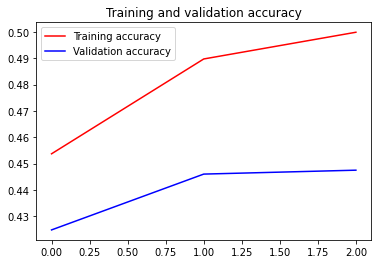

<Figure size 432x288 with 0 Axes>

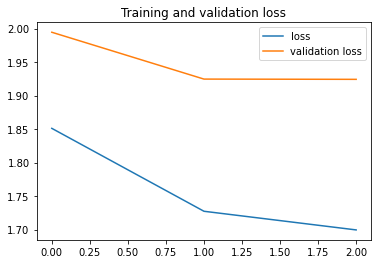

In [223]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    
    # plt.plot(epochs, acc)
    # plt.plot(epochs, val_acc)
    # plt.title('Training and validation accuracy')
    # plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss, label='loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    
    plt.show()
    
plot_history(history, yrange=(0.9,1))

# Evaluate on New Images

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_dir=VALIDATION_DIR
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=3, class_mode='categorical')
# X_test, y_test = next(test_generator)

Testresults = full_model.evaluate(test_generator)
print("test loss, test acc:", Testresults)

Found 57863 images belonging to 46 classes.
19288/19288 [==============================] - 693s 36ms/step - loss: 32.5152 - accuracy: 0.3199
test loss, test acc: [32.515201568603516, 0.3198935389518738]


# Predict vs True

In [220]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=8, class_mode='categorical')
X_test, y_test = next(test_generator)
X_test=X_test/255
preds = full_model.predict(X_test)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_test, axis=1)
print('')

names = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan', 'Capris', 'Cardigan',
         'Chinos', 'Coat', 'Coverup', 'Culottes', 'Cutoffs', 'Dress', 'Flannel', 'Gauchos', 'Halter',
         'Henley', 'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Jodhpurs', 'Joggers', 'Jumpsuit', 'Kaftan',
         'Kimono', 'Leggings', ' Onesie', 'Parka', 'Peancoat', 'Poncho', 'Robe', 'Romper', 'Sarong',
         'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee', 'Top', 'Trunks', 'Turtleneck']

for i in range(0,8):
    class_labels2=[names[i] for i,prob in enumerate(y_test[i]) if prob > 0.0]
    print("Predicted:",names[np.argmax(preds[i])])
    print("True:",names[np.argmax(y_test[i])])
    print('')



Found 57863 images belonging to 46 classes.

Predicted: Dress
True: Dress

Predicted: Dress
True: Dress

Predicted: Tee
True: Tee

Predicted: Tee
True: Tee

Predicted: Tee
True: Sweater

Predicted: Tee
True: Dress

Predicted: Dress
True: Dress

Predicted: Dress
True: Tank



# Save Model

In [54]:
# Save the entire model as a SavedModel.
# !mkdir saved_model
full_model.save('my_model.h5')

# Load Model

In [56]:
# Recreate the exact same model, including its weights and the optimizer
load_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
load_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Load Model Test

In [216]:
# load_model_sample.py
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # load model
    model = load_model("my_model.h5")

    # image path
    img_path = 'Dataset_Split/val/Dress/196026img_00000027.jpg'

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict_step(new_image)
    
    # print(pred[0])
 


In [ ]:
names = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan', 'Capris', 'Cardigan',
         'Chinos', 'Coat', 'Coverup', 'Culottes', 'Cutoffs', 'Dress', 'Flannel', 'Gauchos', 'Halter',
         'Henley', 'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Jodhpurs', 'Joggers', 'Jumpsuit', 'Kaftan',
         'Kimono', 'Leggings', ' Onesie', 'Parka', 'Peancoat', 'Poncho', 'Robe', 'Romper', 'Sarong',
         'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee', 'Top', 'Trunks', 'Turtleneck']
values = np.array(pred[0])

plt.figure(figsize=(64, 5))

plt.subplot(131)
plt.bar(names, values)
# plt.suptitle('Categorical Plotting')
plt.show()